In [1]:
import numpy as np
import pandas as pd
import pickle
import torch.nn as nn
from torch.utils.data import DataLoader
import json, ast, sys, csv, random
import plotly.express as px
import math
import datetime
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt


#Implement training process
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
csv.field_size_limit(sys.maxsize)
URL = "/media/data/ccarmona/memoria/dataset/rl_csvs/"

In [2]:
lr = 0.999
model_name = 'Model_Adam_0.000015'+str(lr)

In [3]:
#ds_rl = pd.read_csv(URL + "ds_rl.csv", engine='python', encoding='utf-8')
n = model_name
#neo_df = pd.read_csv(URL + "neo_df.csv", engine='python', encoding='utf-8')
neo_df_no_history = pd.read_csv(URL + "neo_df_no_history" + str(n) +".csv", engine='python', encoding='utf-8')
neo_df_final = pd.read_csv(URL + "neo_df_final"+ str(n) +".csv", engine='python', encoding='utf-8')

#ql_df = pd.read_csv(URL + "ql_df.csv", engine='python', encoding='utf-8')
ql_df_no_history = pd.read_csv(URL + "ql_df_no_history"+ str(n) +".csv", engine='python', encoding='utf-8')
ql_df_final = pd.read_csv(URL + "ql_df_final"+ str(n) +".csv", engine='python', encoding='utf-8')

#sarsa_df = pd.read_csv(URL + "sarsa_df.csv", engine='python', encoding='utf-8')
sarsa_df_no_history = pd.read_csv(URL + "sarsa_df_no_history"+ str(n) +".csv", engine='python', encoding='utf-8')
sarsa_df_final = pd.read_csv(URL + "sarsa_df_final"+ str(n) +".csv", engine='python', encoding='utf-8')

#exsarsa_df = pd.read_csv(URL + "exsarsa_df.csv", engine='python', encoding='utf-8')
exsarsa_df_no_history = pd.read_csv(URL + "exsarsa_df_no_history"+ str(n) +".csv", engine='python', encoding='utf-8')
exsarsa_df_final = pd.read_csv(URL + "exsarsa_df_final"+ str(n) +".csv", engine='python', encoding='utf-8')

In [4]:
neo_df_final2 = neo_df_final.copy()

In [5]:
neo_df_final2

,index,iteration,pred_old,pred_new,real_old,real_new,mse_old,mse_new,mae_old,mae_new,rmse_old,rmse_new,old_tree,new_tree
0,0,199,50.633167,52.819508,50.0,50.0,0.400901,7.949623,0.633167,2.819508,0.633167,2.819508,"['[""VAR_URI_VARᶲIRI_ID;...direct/P646;""]']","['[""VAR_URI_VARᶲIRI_ID;...direct/P646;""]']"
1,1,199,43.486671,42.610298,50.0,50.0,42.423449,54.607693,6.513329,7.389702,6.513329,7.389702,"['[""VAR_URI_URIᶲIRI_ID;...direct/P31;""]']","['[""VAR_URI_URIᶲIRI_ID;...direct/P31;""]']"
2,2,199,52.109097,46.271168,50.0,50.0,4.448288,13.904190,2.109097,3.728832,2.109097,3.728832,"['[""JOINᶲIRI_ID;...direct/P2045;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P2045;"", [""VAR_URI_V..."
3,3,199,58.678715,47.018269,50.0,50.0,75.320090,8.890722,8.678715,2.981731,8.678715,2.981731,"['[""JOINᶲIRI_ID;...direct/P582;ᶲIRI_ID;...dire...","['[""JOINᶲIRI_ID;...direct/P580;ᶲIRI_ID;...dire..."
4,4,199,50.223892,46.990974,50.0,50.0,0.050128,9.054235,0.223892,3.009026,0.223892,3.009026,"['[""JOINᶲIRI_ID;...direct/P176;"", [""VAR_URI_VA...","['[""JOINᶲIRI_ID;...direct/P176;"", [""VAR_URI_VA..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840,1840,199,86.026924,76.224327,109.0,109.0,527.762215,1074.244735,22.973076,32.775673,22.973076,32.775673,"['[""JOINᶲIRI_ID;...direct/P1725;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P1725;"", [""VAR_VAR_V..."
1841,1841,199,58.641048,58.139881,130.0,130.0,5092.099969,5163.876683,71.358952,71.860119,71.358952,71.860119,"['[""VAR_URI_VARᶲIRI_ID;...direct/P570;""]']","['[""VAR_URI_VARᶲIRI_ID;...direct/P570;""]']"
1842,1842,199,81.492378,71.993782,119.0,119.0,1406.821690,2209.584527,37.507622,47.006218,37.507622,47.006218,"['[""JOINᶲIRI_ID;...direct/P2386;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P2386;"", [""VAR_VAR_V..."
1843,1843,199,86.153290,69.622482,118.0,118.0,1014.212951,2340.384219,31.846710,48.377518,31.846710,48.377518,"['[""JOINᶲIRI_ID;...direct/P189;"", [""VAR_URI_VA...","['[""JOINᶲIRI_ID;...direct/P189;"", [""VAR_VAR_VA..."


### Latencia promedio de cada algoritmo + promedio real

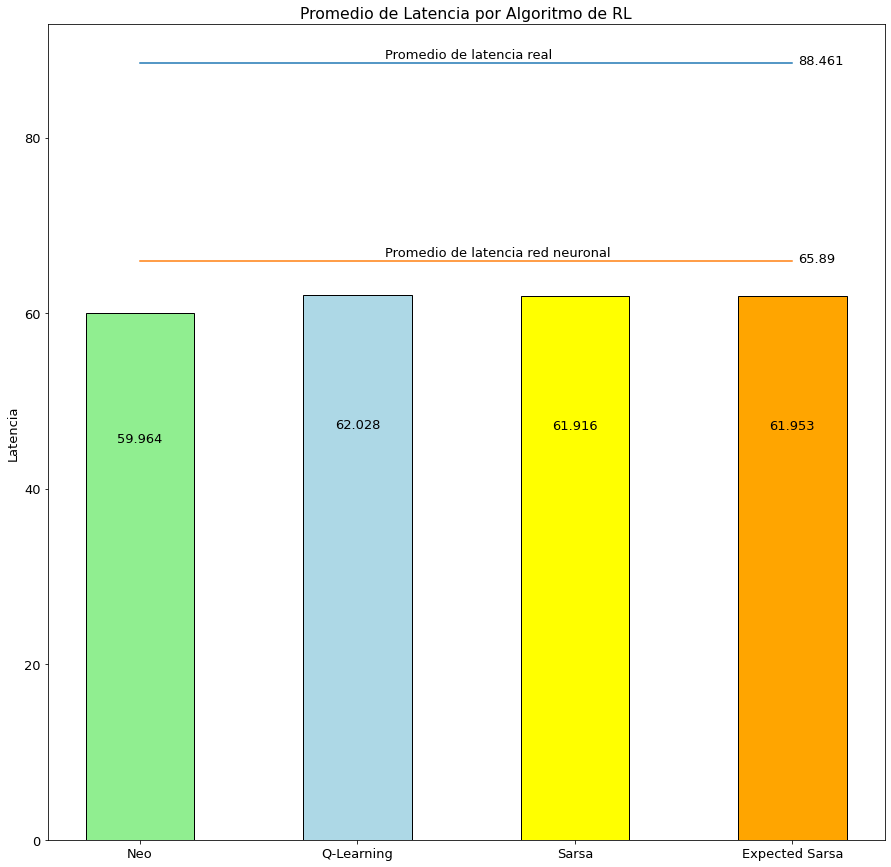

In [6]:
"""
========
Barchart
========

A bar plot with errorbars and height labels on individual bars
"""
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
ind = np.arange(4)*0.4
real_value = [np.mean(ql_df_final['real_new']) for i in range(4)]
old_pred = [np.mean(ql_df_final['pred_old']) for i in range(4)]
h = [
    np.mean(neo_df_final['pred_new']),
    np.mean(ql_df_final['pred_new']),
    np.mean(sarsa_df_final['pred_new']),
    np.mean(exsarsa_df_final['pred_new']),
]
c = ['lightgreen','lightblue','yellow','orange']
names = ('Neo','Q-Learning','Sarsa','Expected Sarsa')

width = 0.2      # the width of the bars

fig, ax = plt.subplots(figsize=(15,15))
rects = ax.bar(ind, h, width, color=c, edgecolor = 'black')
line1 = ax.plot(ind, real_value);
line2 = ax.plot(ind, old_pred);

# add some text for labels, title and axes ticks
ax.set_ylabel('Latencia')
ax.set_title('Promedio de Latencia por Algoritmo de RL')
ax.set_xticks(ind)
ax.set_xticklabels(names)


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.75*height,
                str(round(float(height),3)),
                ha='center', va='bottom')

ax.text(ind[1]+0.05,real_value[0] + 0.55,'Promedio de latencia real')
ax.text(ind[1]+0.05,old_pred[0] + 0.55,'Promedio de latencia red neuronal')
ax.text(ind[3]+0.01,real_value[0] - 0.1,str(round(real_value[0],3)))
ax.text(ind[3]+0.01,old_pred[0] - 0.1,str(round(old_pred[0],2)))
autolabel(rects)


plt.show()

### Latencia promedio por iteración de  cada consulta para cada algoritmo + promedio real

In [7]:
def PromedioPorIteracionFormato(df, num_iter):
    aux_dict = {}
    values_pred = []
    for i in range(num_iter):
        aux_dict[str(i)] = {"index" : 0, "preds" : [], "mean_preds" : []}
    for i in range(len(df)):
        a = [df['index'][i],df['iteration'][i],df['pred_new'][i]]
        aux_dict[str(a[1])]["index"] = a[0]
        aux_dict[str(a[1])]["preds"].append(float(a[2]))
    for k,v in aux_dict.items():
        aux_dict[k]["mean_preds"] = np.mean(aux_dict[k]["preds"])
        values_pred.append(np.mean(aux_dict[k]["preds"]))
    index_list = [int(x) for x in list(aux_dict.keys())]
    return index_list, values_pred
def PromedioPorIteracion(df):
    index_list, values_pred = PromedioPorIteracionFormato(df)
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(index_list, values_pred);

In [8]:
index_list_ql, values_pred_ql = PromedioPorIteracionFormato(ql_df_no_history,200)
index_list_neo, values_pred_neo = PromedioPorIteracionFormato(neo_df_no_history,200)
index_list_sarsa, values_pred_sarsa = PromedioPorIteracionFormato(sarsa_df_no_history,200)
index_list_exsarsa, values_pred_exsarsa = PromedioPorIteracionFormato(exsarsa_df_no_history,200)

In [9]:
real_value = np.ones(len(index_list_ql))*np.mean(ql_df_final['real_new'])
old_predict = np.ones(len(index_list_ql))*np.mean(ql_df_final['pred_old'])

In [10]:
np.mean(ql_df_final['pred_old'])

65.89178881296297

[Text(0.5, 0, 'Iteraciones'), Text(0, 0.5, 'Latencia promedio')]

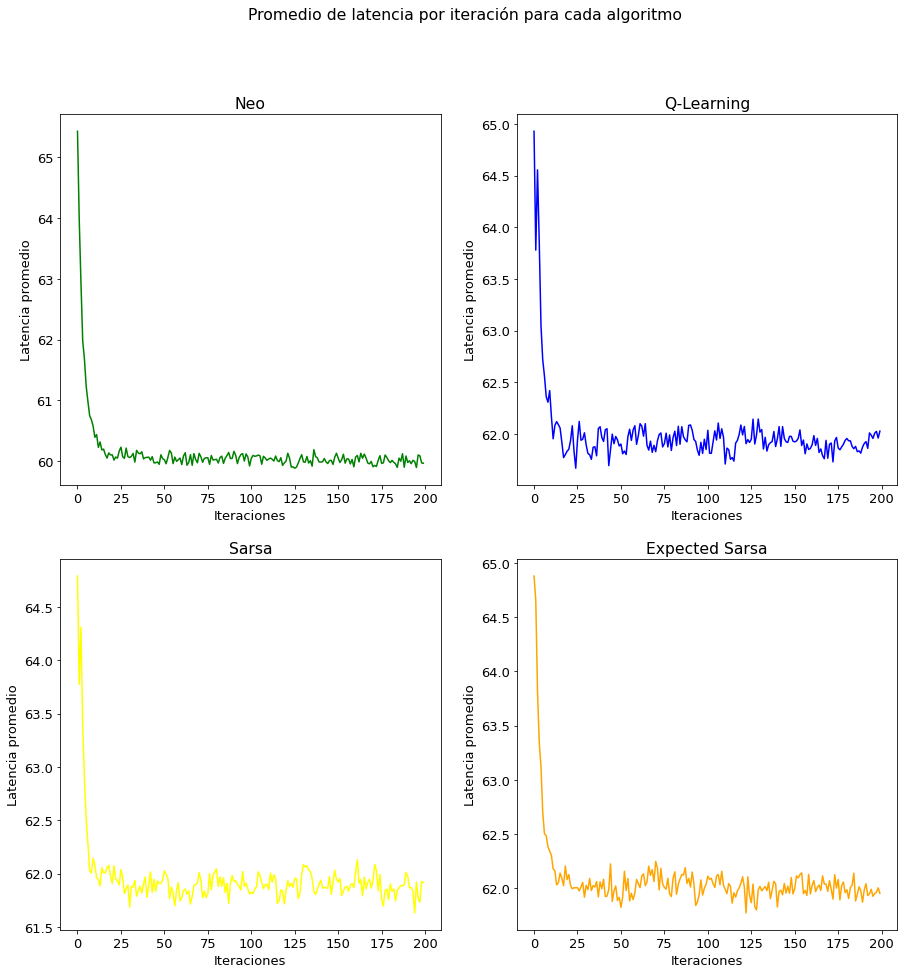

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Some example data to display

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Promedio de latencia por iteración para cada algoritmo')
c = ['green','blue','yellow','orange','grey','black']
ax1.set_title('Neo')
ax1.plot(index_list_neo, values_pred_neo, color=c[0])
#ax1.plot(index_list_neo, real_value, color=c[5], linestyle='dashed')
#ax1.plot(index_list_neo, old_predict, color=c[4], linestyle='dashed')

ax2.set_title('Q-Learning')
ax2.plot(index_list_ql, values_pred_ql, color=c[1])
#ax2.plot(index_list_ql, real_value, color=c[5], linestyle='dashed')
#ax2.plot(index_list_ql, old_predict, color=c[4], linestyle='dashed')

ax3.set_title('Sarsa')
ax3.plot(index_list_sarsa, values_pred_sarsa, color=c[2])
#ax3.plot(index_list_sarsa, real_value, color=c[5], linestyle='dashed')
#ax3.plot(index_list_sarsa, old_predict, color=c[4], linestyle='dashed')

ax4.set_title('Expected Sarsa')
ax4.plot(index_list_exsarsa, values_pred_exsarsa, color=c[3])
#ax4.plot(index_list_exsarsa, real_value, color=c[5], linestyle='dashed')
#ax4.plot(index_list_exsarsa, old_predict, color=c[4], linestyle='dashed')
#for ax in fig.get_axes():
#ax.label_outer()

# set labels
plt.setp(ax1, xlabel='Iteraciones', ylabel='Latencia promedio')
plt.setp(ax2, xlabel='Iteraciones', ylabel='Latencia promedio')
plt.setp(ax3, xlabel='Iteraciones', ylabel='Latencia promedio')
plt.setp(ax4, xlabel='Iteraciones', ylabel='Latencia promedio')


### Consultas mejoradas, consultas iguales, consultas empeoradas

In [12]:
def tag_points(x):
    """Add quality tags of predictions. Used to plot with plotly"""
    difference = x['time'] - x['y_pred'][0]
    abs_diff = np.abs(difference)
    x['y_pred'] = x['y_pred'][0]
    x['query2'] = x['query'].replace(" . ", ' . <br>').replace(" FILTER", '<br> FILTER').replace(" { ", ' { <br>').replace(" } ", ' <br> }').replace(" ; ", ' ; <br>') 
    p20 = x['time'] * 0.2
    p40 = x['time'] * 0.4
    if abs_diff < p20:
        x['color'] = "good prediction"
    elif abs_diff < p40:
        x['color'] = "aceptable prediction"
    else:
        x['color'] = "bad prediction"
    return x

In [13]:
def tag_best_worst_equal(x, tol):
    if (x['new_tree'] == x['old_tree']):
        x['tag'] = "igual"
    else:
        difference = x['pred_old'] - x['pred_new']
        if difference < -tol:
            x['tag'] = "peor"
        elif difference >= -tol and difference <= tol:
            x['tag'] = "igual"
        else:
            x['tag'] = "mejor"

    return x

In [14]:
neo_df_final = neo_df_final.apply(lambda x: tag_best_worst_equal(x,0.01), axis=1)
ql_df_final = ql_df_final.apply(lambda x: tag_best_worst_equal(x,0.01), axis=1)
sarsa_df_final = sarsa_df_final.apply(lambda x: tag_best_worst_equal(x,0.01), axis=1)
exsarsa_df_final = exsarsa_df_final.apply(lambda x: tag_best_worst_equal(x,0.01), axis=1)

In [15]:
def mejor_peor_igual(df):
    try:
        df_mejor = int(df.groupby('tag').count()['index']['mejor'])
    except:
        df_mejor = 0

    try:
        df_peor = int(df.groupby('tag').count()['index']['peor'])
    except:
        df_peor = 0
    try:
        df_igual = int(df.groupby('tag').count()['index']['igual'])
    except:
        df_igual = 0
    return df_mejor, df_peor, df_igual

In [16]:
neo_mejor, neo_peor, neo_igual = mejor_peor_igual(neo_df_final)
ql_mejor, ql_peor, ql_igual = mejor_peor_igual(ql_df_final)
sarsa_mejor, sarsa_peor, sarsa_igual = mejor_peor_igual(sarsa_df_final)
exsarsa_mejor, exsarsa_peor, exsarsa_igual = mejor_peor_igual(exsarsa_df_final)

In [17]:
print(ql_mejor, ql_peor, ql_igual)

684 181 980


In [18]:


ql_igual2 = int(ql_df_final.groupby('tag').count()['index']['igual'])
ql_mejor2 = int(ql_df_final.groupby('tag').count()['index']['mejor'])
ql_peor2 = int(ql_df_final.groupby('tag').count()['index']['peor'])

In [19]:


ql_igual = int(ql_df_final.groupby('tag').count()['index']['igual'])
ql_mejor = int(ql_df_final.groupby('tag').count()['index']['mejor'])
ql_peor = int(ql_df_final.groupby('tag').count()['index']['peor'])

sarsa_igual = int(sarsa_df_final.groupby('tag').count()['index']['igual'])
sarsa_mejor = int(sarsa_df_final.groupby('tag').count()['index']['mejor'])
sarsa_peor = int(sarsa_df_final.groupby('tag').count()['index']['peor'])

exsarsa_igual = int(exsarsa_df_final.groupby('tag').count()['index']['igual'])
exsarsa_mejor = int(exsarsa_df_final.groupby('tag').count()['index']['mejor'])
exsarsa_peor = int(exsarsa_df_final.groupby('tag').count()['index']['peor'])

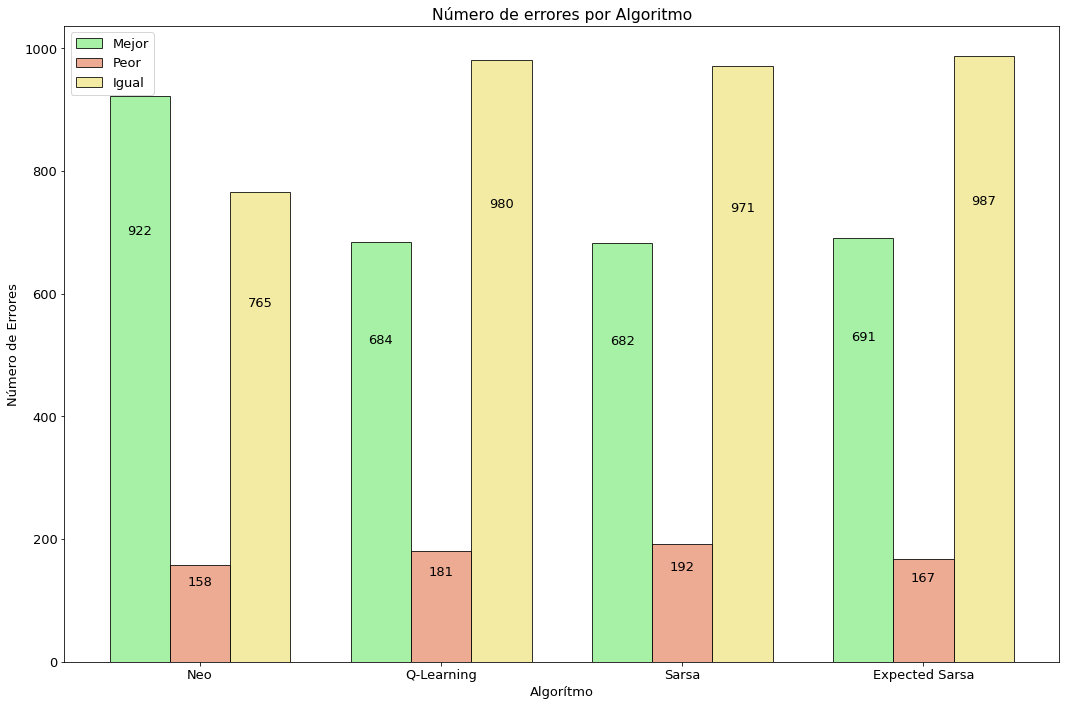

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
# data to plot
n_groups = 4
igual = (neo_igual, ql_igual, sarsa_igual, exsarsa_igual)
mejor = (neo_mejor, ql_mejor, sarsa_mejor, exsarsa_mejor)
peor = (neo_peor, ql_peor, sarsa_peor, exsarsa_peor)

# create plot
fig, ax = plt.subplots(figsize=(15,10))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, mejor, bar_width,
alpha=opacity,
color='lightgreen',
label='Mejor',
edgecolor = 'black')

rects2 = plt.bar(index + bar_width, peor, bar_width,
alpha=opacity,
color='darksalmon',
label='Peor',
edgecolor = 'black')

rects3 = plt.bar(index + 2*bar_width, igual, bar_width,
alpha=opacity,
color='khaki',
label='Igual',
edgecolor = 'black')

plt.xlabel('Algorítmo')
plt.ylabel('Número de Errores')
plt.title('Número de errores por Algoritmo')
plt.xticks(index + bar_width, ('Neo', 'Q-Learning', 'Sarsa', 'Expected Sarsa'))
plt.legend()
plt.tight_layout()


for i in index:
    ax.text(index[i], 
             mejor[i]*0.75,
             str(mejor[i]),
             ha='center', va='bottom',
            )
    ax.text(index[i] + bar_width, 
             peor[i]*0.75,
             str(peor[i]),
             ha='center', va='bottom',
            )
    ax.text(index[i] + 2*bar_width, 
             igual[i]*0.75,
             str(igual[i]),
             ha='center', va='bottom',
            )


plt.show()

##### Por tipo rango de latencia

In [21]:
exsarsa_df_final['real_new'].describe()

count    1845.000000
mean       88.460705
std        27.898507
min        50.000000
25%        64.000000
50%        83.000000
75%       111.000000
max       150.000000
Name: real_new, dtype: float64

In [22]:
def split_by_latency(df_final):
    df = df_final.copy()
    #df_0_10 = df[df['pred_new'] < 10]
    #df_10_20 = df[(df['pred_new'] >= 10) & (df['pred_new'] < 20)]
    #df_20_30 = df[(df['pred_new'] >= 20) & (df['pred_new'] < 30)]
    #df_30_40 = df[(df['pred_new'] >= 30) & (df['pred_new'] < 40)]
    #df_40_50 = df[(df['pred_new'] >= 40) & (df['pred_new'] < 50)]
    #df_50_60 = df[(df['pred_new'] >= 50) & (df['pred_new'] < 60)]
    #df_60 = df[df['pred_new'] >= 60]
    df_50_60 = df[df['real_old'] < 60]
    df_60_70 = df[(df['real_old'] >= 60) & (df['real_old'] < 70)]
    df_70_80 = df[(df['real_old'] >= 70) & (df['real_old'] < 80)]
    df_80_90 = df[(df['real_old'] >= 80) & (df['real_old'] < 90)]
    df_90_100 = df[(df['real_old'] >= 90) & (df['real_old'] < 100)]
    df_100_110 = df[(df['real_old'] >= 100) & (df['real_old'] < 110)]
    df_110_120 = df[(df['real_old'] >= 110) & (df['real_old'] < 120)]
    df_120_150 = df[df['real_old'] >= 120]
    #df_120_130 = df[(df['real_old'] >= 120) & (df['real_old'] < 130)]
    #df_130_140 = df[(df['real_old'] >= 130) & (df['real_old'] < 140)]
    #df_140_150 = df[df['real_old'] >= 140]
    #return df_0_10, df_10_20 ,df_20_30, df_30_40, df_40_50, df_50_60, df_60
    #return df_50_60,df_60_70,df_70_80,df_80_90,df_90_100,df_100_110,df_110_120,df_120_130,df_130_140,df_140_150
    return df_50_60,df_60_70,df_70_80,df_80_90,df_90_100,df_100_110,df_110_120,df_120_150


In [23]:
def plot_errores_rango(df_final,nombre_algoritmo):
    mejor = []
    peor = []
    igual = []
    splitting = split_by_latency(df_final) 
    for df in splitting:
        m, p , i = mejor_peor_igual(df)
        mejor.append(m)
        peor.append(p)
        igual.append(i)
    
    plt.rcParams.update({'font.size': 13})
    # data to plot
    n_groups = len(splitting)
    #igual = (neo_igual, ql_igual, sarsa_igual, exsarsa_igual)
    #mejor = (neo_mejor, ql_mejor, sarsa_mejor, exsarsa_mejor)
    #peor = (neo_peor, ql_peor, sarsa_peor, exsarsa_peor)

    # create plot
    fig, ax = plt.subplots(figsize=(15,10))
    index = np.arange(n_groups)
    bar_width = 0.2
    opacity = 0.8

    rects1 = plt.bar(index, mejor, bar_width,
    alpha=opacity,
    color='lightgreen',
    label='Mejor',
    edgecolor = 'black')

    rects3 = plt.bar(index + bar_width, peor, bar_width,
    alpha=opacity,
    color='darksalmon',
    label='Peor',
    edgecolor = 'black')
    
    rects2 = plt.bar(index + 2*bar_width, igual, bar_width,
    alpha=opacity,
    color='khaki',
    label='Igual',
    edgecolor = 'black')

    plt.xlabel('Rango de latencia')
    plt.ylabel('Número de Errores')
    plt.title(f'Número de errores {nombre_algoritmo} por rangos de latencia')
    plt.xticks(index + bar_width, ('[50-60)',
                                   '[60-70)',
                                   '[70-80)',
                                   '[80-90)',
                                   '[90-100)',
                                   '[100-110)',
                                   '[110-120)',
                                   '[120-150]'))
    plt.legend()
    plt.tight_layout()


    for i in index:
        ax.text(index[i], 
                 mejor[i]*0.75,
                 str(mejor[i]),
                 ha='center', va='bottom',
                )
        ax.text(index[i] + bar_width, 
                 peor[i]*0.75,
                 str(peor[i]),
                 ha='center', va='bottom',
                )
        ax.text(index[i] + 2*bar_width, 
                 igual[i]*0.75,
                 str(igual[i]),
                 ha='center', va='bottom',
                )
    plt.show()

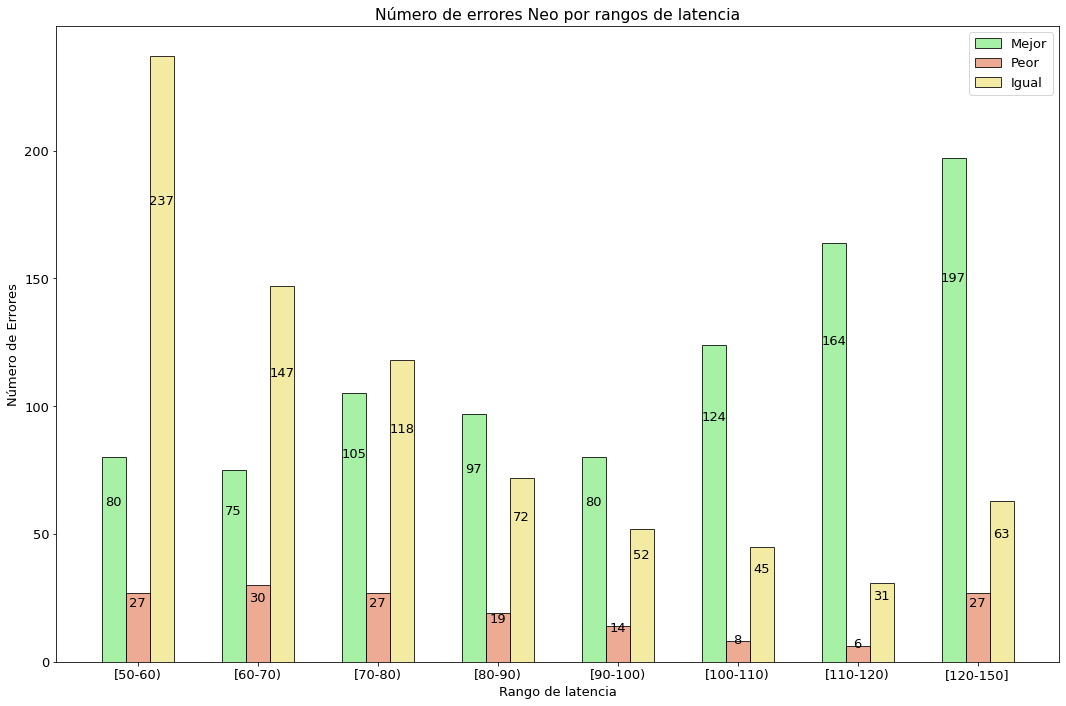

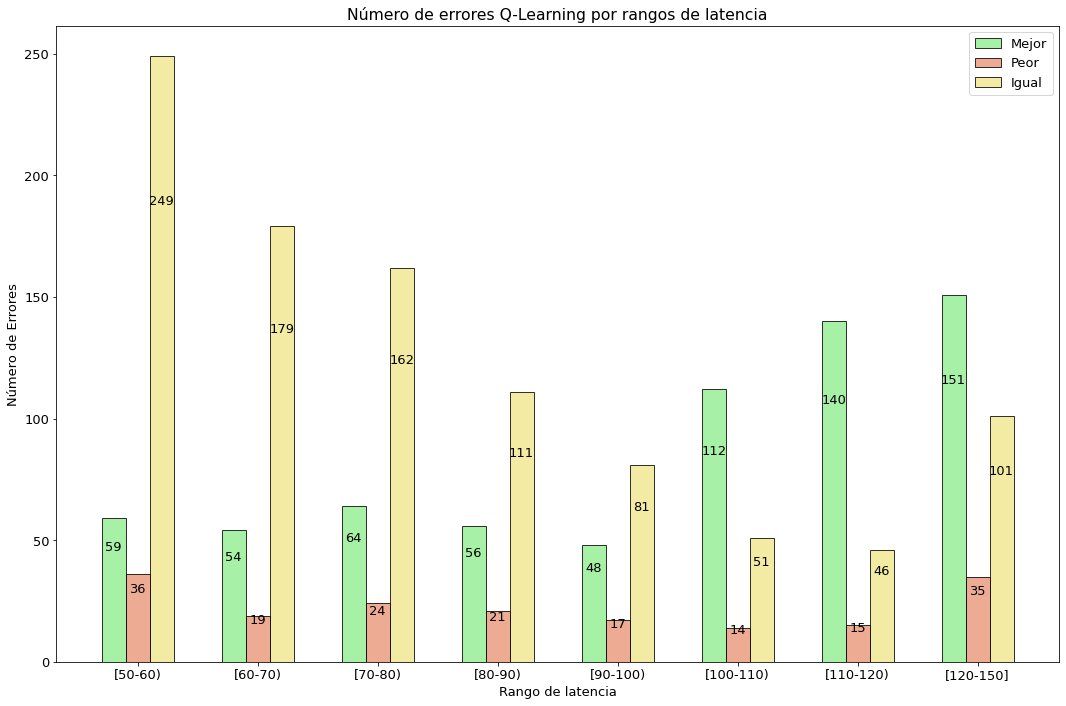

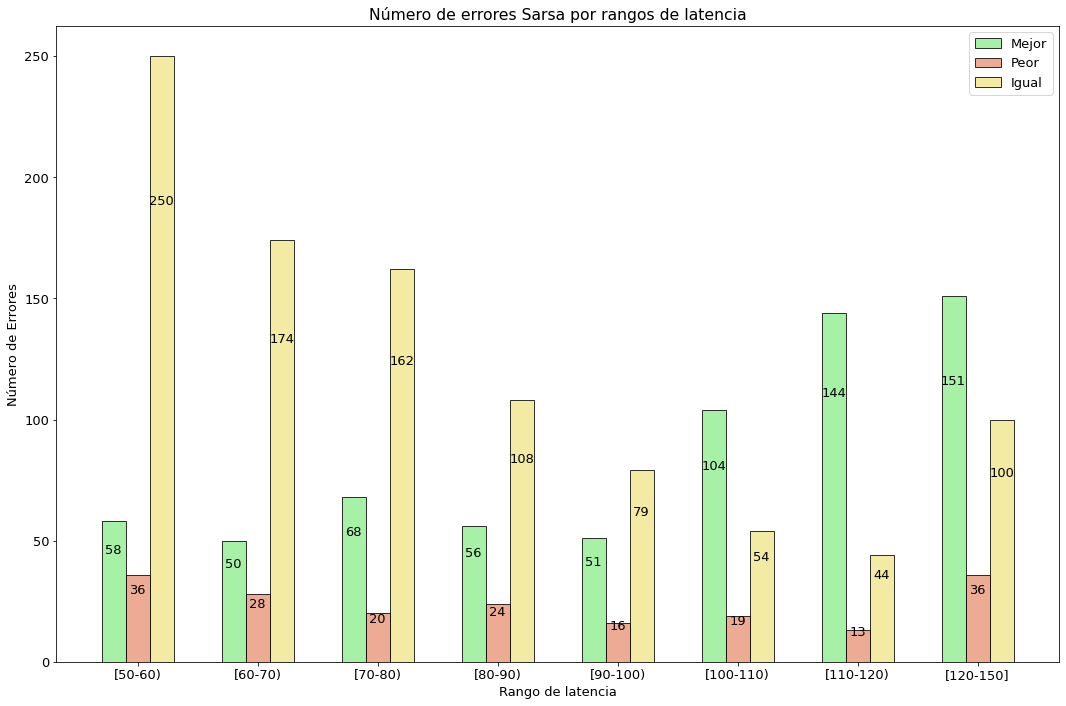

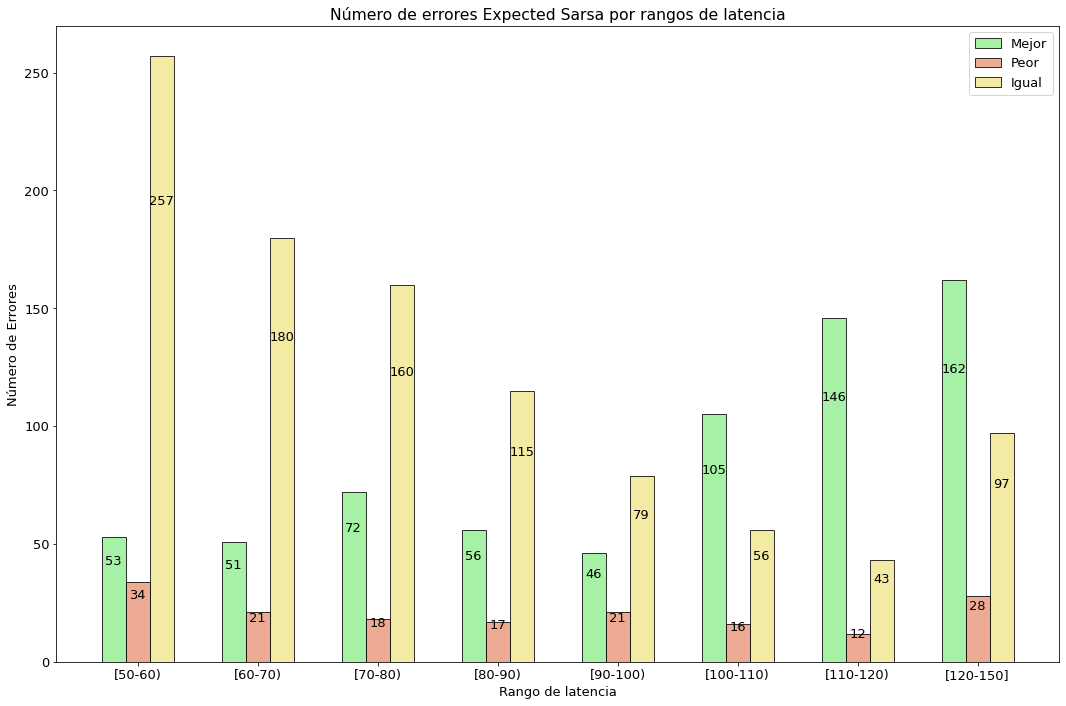

In [24]:
plot_errores_rango(neo_df_final,'Neo')
plot_errores_rango(ql_df_final,'Q-Learning')
plot_errores_rango(sarsa_df_final,'Sarsa')
plot_errores_rango(exsarsa_df_final,'Expected Sarsa')

### Latencia promedio de cada consulta diferenciado por numero de JOINs para cada algoritmo

In [25]:
def split_by_joins(df, val):
    joins_1_p, joins_1_e =[],[]
    joins_2_p, joins_2_e =[],[]
    joins_3_p, joins_3_e =[],[]
    joins_4_p, joins_4_e =[],[]
    joins_5_p, joins_5_e =[],[]
    joins_6_p, joins_6_e =[],[]
    #<
    #>
    columns = 'tag'
    for i in range(len(df)):
        count_joins = df['new_tree'][i].count('JOIN') 
        print(count_joins)
        if count_joins == 1:
            joins_1_p.append(df[val][i])
            joins_1_e.append(df['tag'][i])
        elif count_joins == 2:
            joins_2_p.append(df[val][i])
            joins_2_e.append(df['tag'][i])       
        elif count_joins == 3:
            joins_3_p.append(df[val][i])
            joins_3_e.append(df['tag'][i])       
        elif count_joins == 4:
            joins_4_p.append(df[val][i])
            joins_4_e.append(df['tag'][i])       
        elif count_joins == 5:
            joins_5_p.append(df[val][i])
            joins_5_e.append(df['tag'][i])       
        else:
            joins_6_p.append(df[val][i])
            joins_6_e.append(df['tag'][i])       
    promedio = [joins_1_p, joins_2_p, joins_3_p, joins_4_p, joins_5_p, joins_6_p]
    errores = [joins_1_e, joins_2_e, joins_3_e, joins_4_e, joins_5_e, joins_6_e]
    return promedio, errores 


In [26]:
original_p_joins, original_e_joins = split_by_joins(neo_df_final, 'real_old')
neo_p_joins, neo_e_joins = split_by_joins(neo_df_final,'pred_new')
ql_p_joins, ql_e_joins = split_by_joins(ql_df_final, 'pred_new')
sarsa_p_joins, sarsa_e_joins = split_by_joins(sarsa_df_final, 'pred_new')
exsarsa_p_joins, exsarsa_e_joins = split_by_joins(exsarsa_df_final, 'pred_new')

0
0
1
1
1
1
1
0
1
0
1
1
1
1
0
2
0
1
1
2
1
0
1
1
1
1
2
2
1
1
1
1
1
1
0
0
1
0
1
1
1
1
1
0
1
2
1
1
1
1
1
1
1
1
1
2
0
1
1
0
3
1
2
1
1
2
1
0
1
1
0
1
1
1
3
1
1
1
1
1
1
2
1
2
1
3
1
1
1
2
1
1
1
1
0
1
3
1
1
1
3
3
1
0
8
2
1
1
3
1
0
1
1
0
2
1
1
2
0
1
1
0
1
1
1
0
1
0
1
0
1
2
1
2
1
1
2
0
0
1
1
1
1
1
0
2
2
1
0
1
1
0
2
1
1
1
1
1
3
1
1
1
1
1
1
1
1
2
0
2
2
1
3
1
3
1
1
0
0
1
1
1
0
2
0
0
1
0
1
1
1
1
2
7
1
1
1
1
1
1
1
2
1
1
1
2
5
1
2
1
1
1
2
1
0
1
1
1
6
0
1
0
1
1
1
2
1
0
3
1
0
3
0
0
1
0
3
1
0
1
1
1
2
1
2
1
2
0
0
1
2
1
1
1
1
5
1
3
1
1
1
1
1
2
3
1
1
1
1
1
0
0
0
1
0
1
1
1
1
0
1
0
2
0
1
1
1
2
1
1
4
0
1
1
3
1
1
1
0
1
0
1
1
1
1
1
1
0
1
0
1
1
2
0
2
1
1
1
2
1
1
0
1
2
0
3
1
3
1
1
2
1
1
1
1
1
3
1
1
1
1
1
1
1
1
2
2
2
1
3
1
1
1
1
1
0
2
1
3
1
1
1
0
1
1
1
1
1
0
0
12
3
2
1
1
1
0
1
0
0
0
0
2
2
1
1
1
1
3
1
1
1
1
1
0
1
1
1
1
0
1
7
4
1
0
2
1
0
1
1
0
0
0
0
0
1
1
1
1
1
2
1
0
2
1
1
2
2
1
7
1
3
1
0
1
0
0
1
0
0
1
2
1
0
1
1
1
1
8
1
1
0
1
1
2
1
1
2
1
0
1
0
0
1
1
2
1
0
1
1
0
1
1
1
1
3
0
1
1
0
2
1
0
1
1
2
2
2
1
1
1
3
1
1
2
1
0
2
1
2

0
0
0
1
2
4
0
1
0
1
1
1
2
3
0
1
0
1
0
2
0
1
1
0
0
1
1
2
3
1
2
1
1
6
1
0
3
0
0
1
0
0
0
1
0
1
1
0
1
1
1
1
0
0
1
1
6
2
1
1
1
0
0
6
2
1
0
1
1
1
0
3
1
1
1
2
2
1
0
1
3
1
1
2
0
1
1
0
0
1
2
1
0
0
3
1
0
1
1
0
2
2
1
0
1
1
2
1
3
0
1
0
2
2
1
1
1
1
1
1
6
1
3
2
1
1
2
0
1
7
1
1
1
0
1
6
2
2
1
1
1
1
6
1
0
1
1
2
1
1
1
1
1
6
0
2
2
0
0
1
1
6
1
1
1
2
1
0
3
0
1
1
9
1
11
1
0
1
0
1
1
1
1
2
1
1
0
1
1
1
1
2
0
1
1
0
1
0
1
2
0
1
2
2
0
1
2
0
2
0
1
0
0
1
1
4
1
1
0
4
6
2
1
1
3
1
0
1
1
1
0
2
1
1
2
1
6
0
1
1
2
0
2
3
1
1
1
1
2
0
0
1
3
0
1
3
0
6
1
1
1
2
1
1
1
1
1
1
0
3
1
1
2
2
1
1
2
2
1
1
1
2
2
3
1
1
6
1
1
1
0
1
2
0
2
2
1
2
1
1
1
2
2
1
1
0
1
1
3
1
2
1
1
1
0
1
1
6
2
0
1
1
3
3
1
3
6
1
1
1
0
1
1
2
1
0
1
0
0
1
1
2
2
0
2
2
1
1
1
1
0
1
1
1
0
1
1
1
1
1
2
2
1
1
1
1
2
1
1
2
1
2
1
0
2
0
1
1
2
2
2
1
2
1
1
1
2
1
8
1
1
6
1
0
1
1
1
2
1
0
0
1
0
1
1
1
0
1
0
1
1
3
2
0
1
3
6
6
2
3
1
2
2
0
2
1
2
0
2
1
2
3
3
2
1
2
4
1
1
2
1
2
1
1
1
1
2
0
1
2
1
2
1
2
1
2
1
0
1
3
2
1
1
1
2
0
1
1
1
1
1
0
1
3
1
1
2
2
0
1
1
2
0
1
0
0
1
1
1
1
1
6
2
0
0
1
1
2
0
1

In [27]:
len(exsarsa_p_joins[0])

1005

[[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 57.0, 52.0, 53.0, 53.0, 60.0, 58.0, 58.0, 60.0, 58.0, 53.0, 53.0, 57.0, 57.0, 59.0, 55.0, 60.0, 58.0, 54.0, 52.0, 55.0, 55.0, 53.0, 58.0, 54.0, 55.0, 54.0, 58.0, 58.0, 56.0, 55.0, 53.0, 51.0, 60.0, 58.0, 56.0, 54.0, 54.0, 54.0, 60.0, 52.0, 52.0, 56.0, 55.0, 56.0, 55.0, 53.0, 56.0, 59.0, 52.0, 56.0, 60.0, 60.0, 55.0, 53.0, 51.0, 53.0, 52.0, 60.0, 59.0, 55.0, 54.0, 59.0, 59.0, 60.0, 51.0, 53.0, 56.0, 51.0, 51.0, 51.0, 51.0, 54.0, 53.0, 55.0, 59.0, 56.0, 52.0, 58.0, 52.0, 54.0, 53.0, 54.0, 54.0, 52.0, 56.0, 59.0, 60.0, 56.0, 55.0, 60.0, 53.0, 52.0, 58.0, 53.0, 57.0, 58.0, 51.0, 53.0, 53.0, 58.0, 57.0, 57.0, 54.0, 51.0, 57.0, 56.0, 57.0, 53.0, 55.0, 54.0, 57.0, 51.0, 52.0, 54.0, 51.0, 53.0, 56.0, 58.0, 53.0, 54.0, 58.0, 55.0, 51.0, 53.0, 56.0, 54.0, 59.0, 53.0, 57.0, 60.0, 53.0, 58.0, 60.0, 53.0, 56.0, 53.0, 53.0, 57.0, 58.0, 53.0, 58.0, 51.0, 52.0, 56

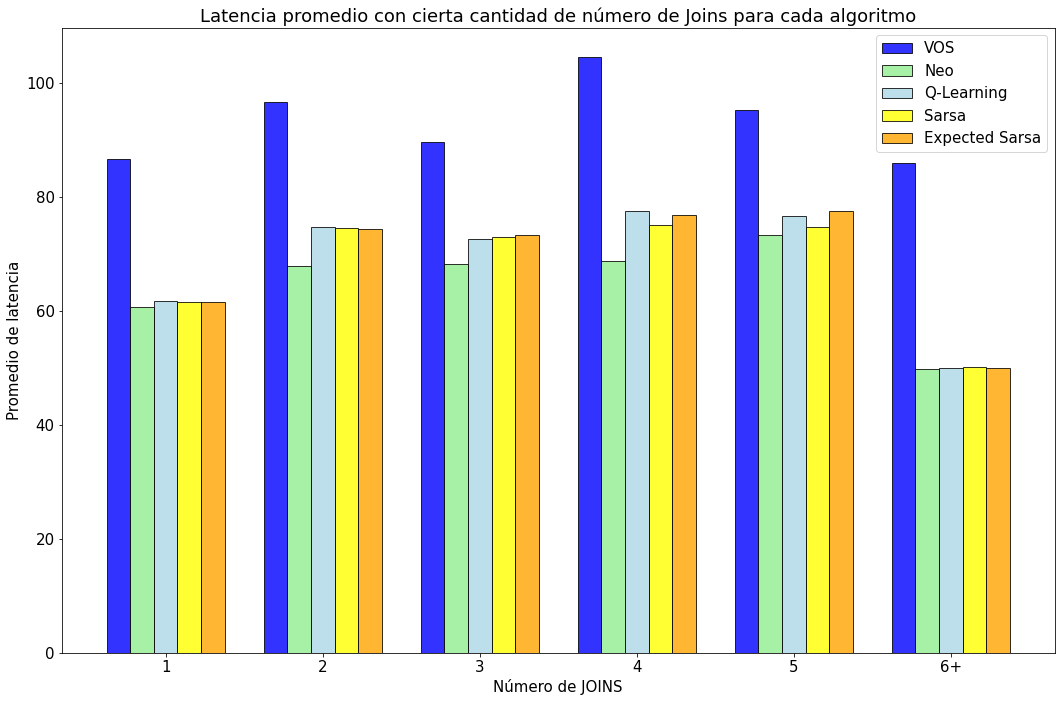

In [100]:

plt.rcParams.update({'font.size': 15})
# data to plot
n_groups = len(neo_p_joins)
    #igual = (neo_igual, ql_igual, sarsa_igual, exsarsa_igual)
    #mejor = (neo_mejor, ql_mejor, sarsa_mejor, exsarsa_mejor)
    #peor = (neo_peor, ql_peor, sarsa_peor, exsarsa_peor)

 # create plot
fig, ax = plt.subplots(figsize=(15,10))
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8
c = ['blue','lightgreen','lightblue','yellow','orange']


mean_original = np.array([np.mean(val) for val in original_p_joins])
mean_neo = np.array([np.mean(val) for val in neo_p_joins])
mean_ql = np.array([np.mean(val) for val in ql_p_joins])
mean_sarsa = np.array([np.mean(val) for val in sarsa_p_joins])
mean_exsarsa = np.array([np.mean(val) for val in exsarsa_p_joins])


rects_original = plt.bar(index, mean_original, bar_width,
alpha=opacity,
color=c[0],
edgecolor = 'black',
label='VOS')
rects_neo = plt.bar(index+bar_width, mean_neo, bar_width,
alpha=opacity,
color=c[1],
edgecolor = 'black',
label='Neo')
rects_ql = plt.bar(index+bar_width*2, mean_ql, bar_width,
alpha=opacity,
color=c[2],
edgecolor = 'black',
label='Q-Learning')
rects_sarsa = plt.bar(index+bar_width*3, mean_sarsa, bar_width,
alpha=opacity,
color=c[3],
edgecolor = 'black',
label='Sarsa')
rects_exsarsa = plt.bar(index+bar_width*4, mean_exsarsa, bar_width,
alpha=opacity,
color=c[4],
edgecolor = 'black',
label='Expected Sarsa')


plt.xlabel('Número de JOINS')
plt.ylabel('Promedio de latencia')
plt.title(f'Latencia promedio con cierta cantidad de número de Joins para cada algoritmo')
plt.xticks(index+bar_width*2, ('1','2','3','4','5','6+'))
plt.legend()
plt.tight_layout()




plt.show()

### Consultas mejoradas, consultas iguales, consultas empeoradas diferenciados por numero de JOINs

In [29]:
def plot_errores_join(lista_e_join,nombre_algoritmo):
    igual = []
    mejor = []
    peor = []
    for j in lista_e_join:
        i, m, p = j.count('igual'), j.count('mejor'), j.count('peor')
        igual.append(i)
        mejor.append(m)
        peor.append(p)
    plt.rcParams.update({'font.size': 13})
    # data to plot
    n_groups = len(igual)
    #igual = (neo_igual, ql_igual, sarsa_igual, exsarsa_igual)
    #mejor = (neo_mejor, ql_mejor, sarsa_mejor, exsarsa_mejor)
    #peor = (neo_peor, ql_peor, sarsa_peor, exsarsa_peor)

    # create plot
    fig, ax = plt.subplots(figsize=(15,10))
    index = np.arange(n_groups)
    bar_width = 0.15
    opacity = 0.8

    rects1 = plt.bar(index, mejor, bar_width,
    alpha=opacity,
    color='lightgreen',
    label='Mejor',
    edgecolor = 'black')

    rects2 = plt.bar(index + bar_width, igual, bar_width,
    alpha=opacity,
    color='khaki',
    label='Igual',
    edgecolor = 'black')

    rects3 = plt.bar(index + 2*bar_width, peor, bar_width,
    alpha=opacity,
    color='darksalmon',
    label='Peor',
    edgecolor = 'black')

    plt.xlabel('Número de JOINS')
    plt.ylabel('Promedio de latencia')
    plt.title(f'Número de errores por número de JOINS para algoritmo {nombre_algoritmo}')
    plt.xticks(index + bar_width, ('1','2','3','4','5','6+'))
    plt.legend()
    plt.tight_layout()


    for i in index:
        ax.text(index[i], 
                 mejor[i]*0.7,
                 str(mejor[i]),
                 ha='center', va='bottom',
                )
        ax.text(index[i] + bar_width, 
                 igual[i]*0.75,
                 str(igual[i]),
                 ha='center', va='bottom',
                )
        ax.text(index[i] + 2*bar_width, 
                 peor[i]*0.75,
                 str(peor[i]),
                 ha='center', va='bottom',
                )
    plt.show()

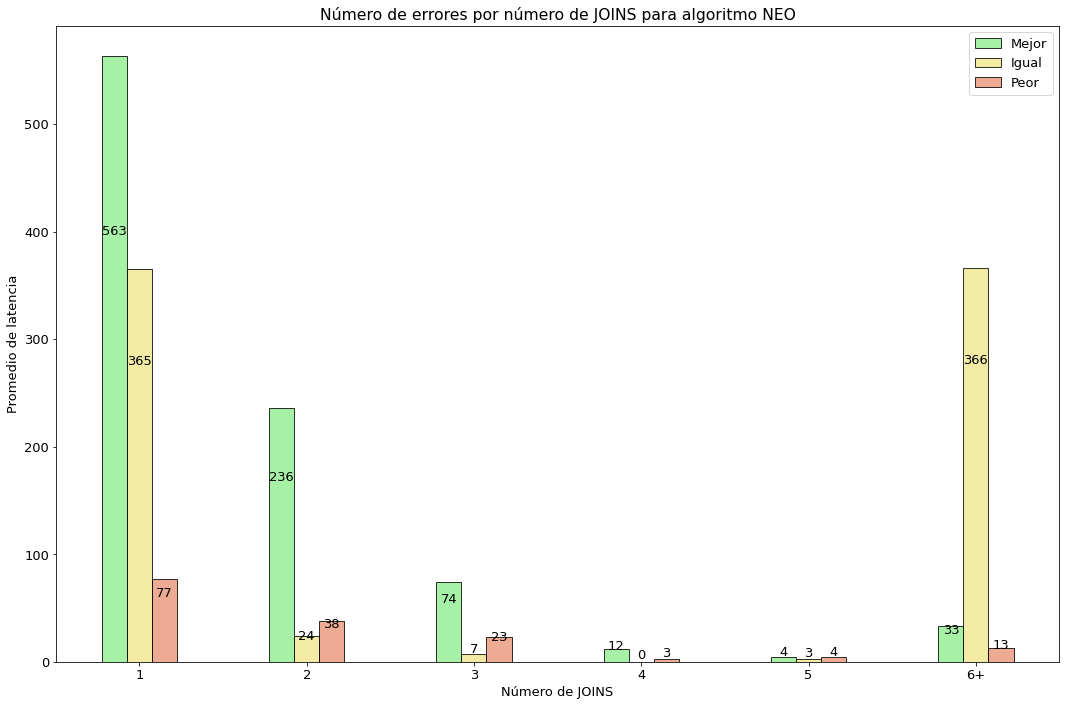

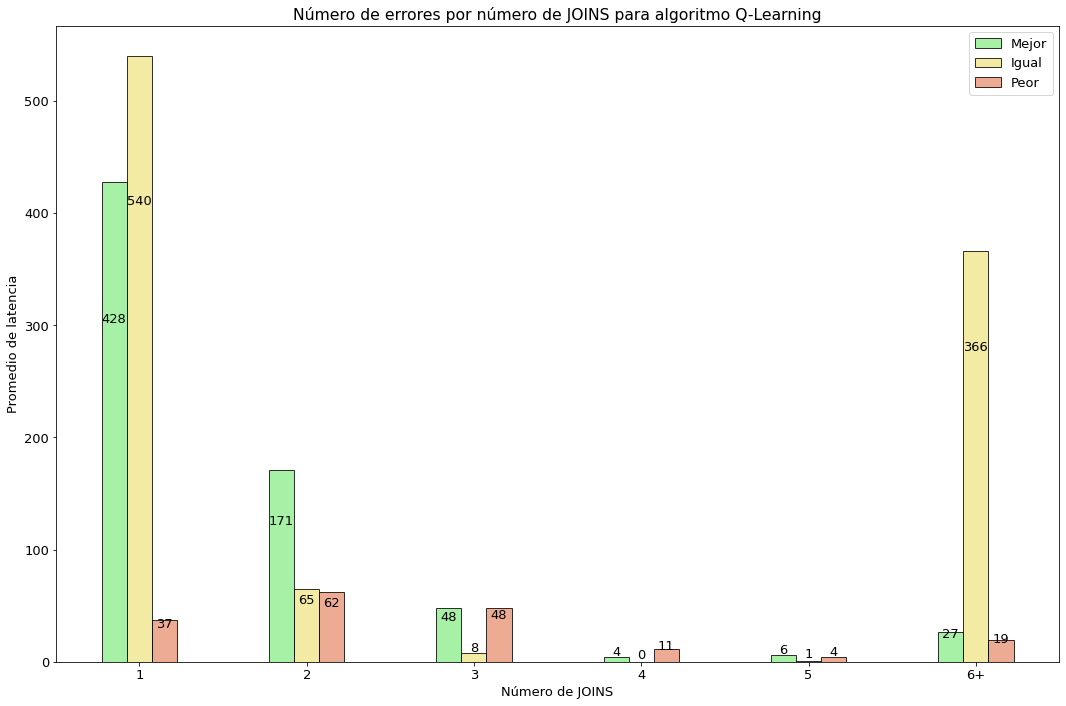

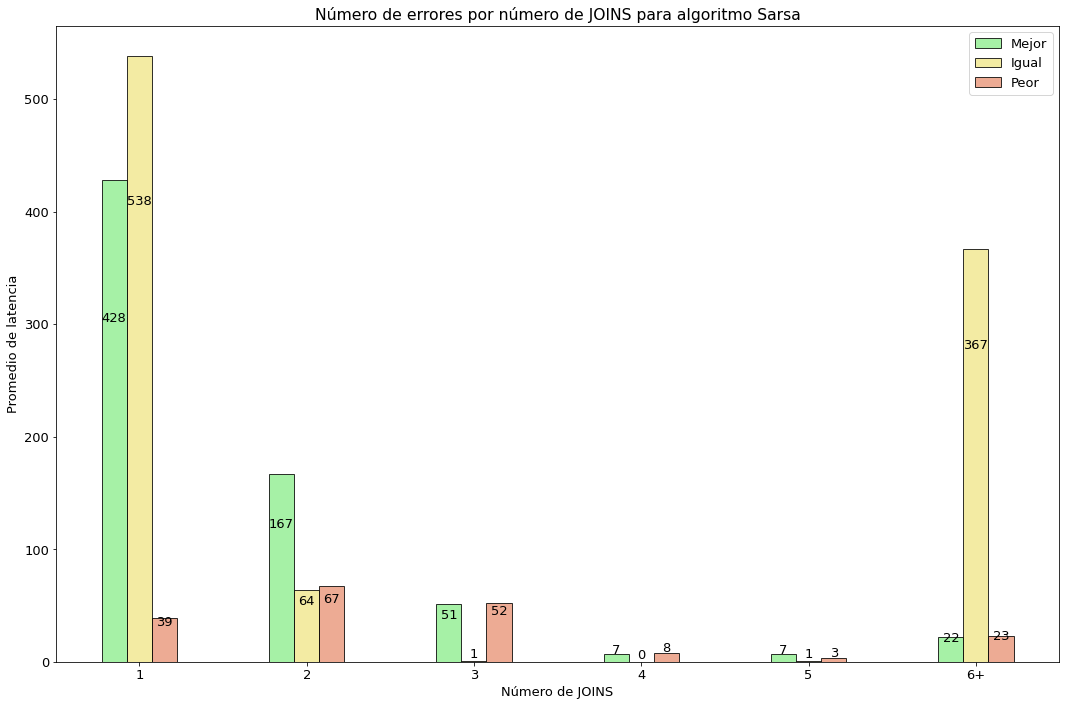

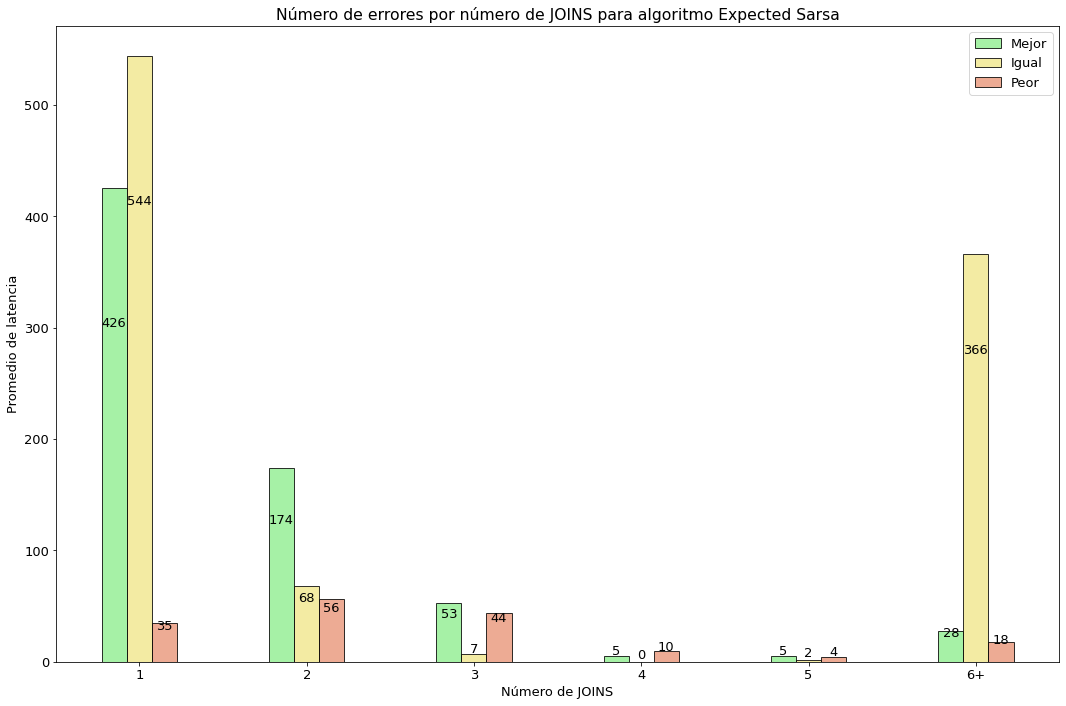

In [30]:
plot_errores_join(neo_e_joins,'NEO')
plot_errores_join(ql_e_joins,'Q-Learning')
plot_errores_join(sarsa_e_joins,'Sarsa')
plot_errores_join(exsarsa_e_joins,'Expected Sarsa')

### RMSE y MAE Por iteración

In [31]:
#ds_rl
#neo_df_final
#ql_df_final
#sarsa_df_final
#exsarsa_df_final

In [32]:
neo_df_no_history[['mse_new','mse_old']]

,mse_new,mse_old
0,0.535219,1.648931
1,3.286359,10.233341
2,13.853143,1.382408
3,1.693024,2.664495
4,11.782494,0.209624
...,...,...
368995,1775.686314,955.817948
368996,1382.482910,1369.795037
368997,1986.668500,839.407295
368998,1931.708862,1144.579494


In [33]:
df = neo_df_no_history.copy()

In [70]:
df.keys()

Index(['index', 'iteration', 'pred_old', 'pred_new', 'real_old', 'real_new',
       'mse_old', 'mse_new', 'mae_old', 'mae_new', 'rmse_old', 'rmse_new',
       'old_tree', 'new_tree'],
      dtype='object')

In [55]:
len(neo_df_final)

1845

In [ ]:
len(values_pred_ql)

In [41]:
len(values_pred_ql)

200

In [ ]:
mseval = mean_squared_error(y_real_val, y_pred_val)
    maeval = mean_absolute_error(y_real_val, y_pred_val)
    rmseval = np.sqrt(mseval)

In [80]:
def PromedioyOriginalPorIteracionFormato(df, num_iter):
    iter_dict = {}
    values_pred = []
    for i in range(num_iter):
        iter_dict[str(i)] = {"pred_new" : [], "mean_pred_new" : 0, 
                            "pred_old" : [], "mean_pred_old" : 0, 
                            "real" : [], "mean_real" : 0}
    for i in range(len(df)):
        a = [df['index'][i],df['iteration'][i],
             df['pred_new'][i],
             df['real_old'][i],
             df['pred_old'][i]]
        iter_dict[str(a[1])]["pred_new"].append(float(a[2]))
        iter_dict[str(a[1])]["real"].append(float(a[3]))
        iter_dict[str(a[1])]["pred_old"].append(float(a[4]))
    for k,v in iter_dict.items():
        iter_dict[k]["mean_pred_new"] = np.mean(iter_dict[k]["pred_new"])
        iter_dict[k]["mean_pred_old"] = np.mean(iter_dict[k]["pred_old"])
        iter_dict[k]["mean_real"] = np.mean(iter_dict[k]["real"])
    index_list = [int(x) for x in list(iter_dict.keys())]
    return index_list, iter_dict

In [81]:
#index_list_ql, iter_dict_ql = PromedioyOriginalPorIteracionFormato(ql_df_no_history,200)
index_list_neo, iter_dict_neo = PromedioyOriginalPorIteracionFormato(neo_df_no_history,200)
#index_list_sarsa, iter_dict_sarsa = PromedioyOriginalPorIteracionFormato(sarsa_df_no_history,200)
#index_list_exsarsa, iter_dict_exsarsa = PromedioyOriginalPorIteracionFormato(exsarsa_df_no_history,200)

In [97]:
rmse_list_new = []
rmse_list_old = []
mae_list_new = []
mae_list_old = []
for i in index_list_neo:
    rmse_list_new.append(np.sqrt(mean_squared_error(iter_dict_neo[str(i)]['real'], aux_dict_neo[str(i)]['pred_new'])))
    rmse_list_old.append(np.sqrt(mean_squared_error(iter_dict_neo[str(i)]['real'], aux_dict_neo[str(i)]['pred_old'])))
    mae_list_new.append(mean_absolute_error(iter_dict_neo[str(i)]['real'], aux_dict_neo[str(i)]['pred_new']))
    mae_list_old.append(mean_absolute_error(iter_dict_neo[str(i)]['real'], aux_dict_neo[str(i)]['pred_new']))

34.38733710910905

1182.4889534555082

In [85]:
neo_df_final

,index,iteration,pred_old,pred_new,real_old,real_new,mse_old,mse_new,mae_old,mae_new,rmse_old,rmse_new,old_tree,new_tree,tag
0,0,199,50.633167,52.819508,50.0,50.0,0.400901,7.949623,0.633167,2.819508,0.633167,2.819508,"['[""VAR_URI_VARᶲIRI_ID;...direct/P646;""]']","['[""VAR_URI_VARᶲIRI_ID;...direct/P646;""]']",igual
1,1,199,43.486671,42.610298,50.0,50.0,42.423449,54.607693,6.513329,7.389702,6.513329,7.389702,"['[""VAR_URI_URIᶲIRI_ID;...direct/P31;""]']","['[""VAR_URI_URIᶲIRI_ID;...direct/P31;""]']",igual
2,2,199,52.109097,46.271168,50.0,50.0,4.448288,13.904190,2.109097,3.728832,2.109097,3.728832,"['[""JOINᶲIRI_ID;...direct/P2045;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P2045;"", [""VAR_URI_V...",igual
3,3,199,58.678715,47.018269,50.0,50.0,75.320090,8.890722,8.678715,2.981731,8.678715,2.981731,"['[""JOINᶲIRI_ID;...direct/P582;ᶲIRI_ID;...dire...","['[""JOINᶲIRI_ID;...direct/P580;ᶲIRI_ID;...dire...",mejor
4,4,199,50.223892,46.990974,50.0,50.0,0.050128,9.054235,0.223892,3.009026,0.223892,3.009026,"['[""JOINᶲIRI_ID;...direct/P176;"", [""VAR_URI_VA...","['[""JOINᶲIRI_ID;...direct/P176;"", [""VAR_URI_VA...",igual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840,1840,199,86.026924,76.224327,109.0,109.0,527.762215,1074.244735,22.973076,32.775673,22.973076,32.775673,"['[""JOINᶲIRI_ID;...direct/P1725;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P1725;"", [""VAR_VAR_V...",mejor
1841,1841,199,58.641048,58.139881,130.0,130.0,5092.099969,5163.876683,71.358952,71.860119,71.358952,71.860119,"['[""VAR_URI_VARᶲIRI_ID;...direct/P570;""]']","['[""VAR_URI_VARᶲIRI_ID;...direct/P570;""]']",igual
1842,1842,199,81.492378,71.993782,119.0,119.0,1406.821690,2209.584527,37.507622,47.006218,37.507622,47.006218,"['[""JOINᶲIRI_ID;...direct/P2386;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P2386;"", [""VAR_VAR_V...",mejor
1843,1843,199,86.153290,69.622482,118.0,118.0,1014.212951,2340.384219,31.846710,48.377518,31.846710,48.377518,"['[""JOINᶲIRI_ID;...direct/P189;"", [""VAR_URI_VA...","['[""JOINᶲIRI_ID;...direct/P189;"", [""VAR_VAR_VA...",mejor
